In [1]:
import pandas as pd
import numpy as np
import sys, os
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
import pickle

if os.getcwd()[-4:] == "code":
    os.chdir('../')

icu = './data/mimic-iv-2.2-parquet/icu/'
hosp = './data/mimic-iv-2.2-parquet/hosp/'

pd.set_option('mode.chained_assignment',  None) # 경고 off

In [2]:
d_items     = pd.read_parquet(icu+'d_items.parquet')
inputevents = pd.read_parquet(icu+'inputevents.parquet')
icustays    = pd.read_parquet(icu+'icustays.parquet')

In [3]:
admissions = pd.read_parquet(hosp+'admissions.parquet')

In [4]:
icustays_intime = icustays[['subject_id','hadm_id','stay_id','intime']]
icustays_intime['intime'] = pd.to_datetime(icustays_intime['intime'])
icustays_intime = icustays_intime.rename(columns={'intime':'starttime'})

icustays_outtime = icustays[['subject_id','hadm_id','stay_id','outtime']]
icustays_outtime['outtime'] = pd.to_datetime(icustays_outtime['outtime'])
icustays_outtime = icustays_outtime.rename(columns={'outtime':'starttime'})

# Antibiotics

In [5]:
d_antibiotics = d_items[(d_items['linksto']=='inputevents')&(d_items['category']=='Antibiotics')]
d_antibiotics = d_antibiotics[['itemid','label']]
d_antibiotics.reset_index(inplace=True)

# non-Antibiotics 제거
d_antibiotics = d_antibiotics[~d_antibiotics['itemid'].isin([
    225898,225877,225895,225868,225869,225885,225905,225838,
    225848,225844,225896,225837,225873,228003,225871,225903])]
d_antibiotics.dropna(subset='itemid',inplace=True)
d_antibiotics.reset_index(drop=True,inplace=True)

In [6]:
inputevents_antibiotics = inputevents[inputevents['itemid'].isin(d_antibiotics.itemid.unique())]
inputevents_antibiotics['count'] = 1

inputevents_antibiotics = inputevents_antibiotics[['stay_id','starttime','itemid','count']]
inputevents_antibiotics['starttime'] = pd.to_datetime(inputevents_antibiotics['starttime'])

inputevents_antibiotics.sort_values(by=['stay_id','starttime'],ascending=True,inplace=True)
inputevents_antibiotics.reset_index(drop=True,inplace=True)

d_antibiotics = pd.merge(d_antibiotics,inputevents_antibiotics.groupby('itemid')['count'].sum(), on='itemid', how='left')
d_antibiotics.dropna(subset='count',inplace=True)
d_antibiotics.sort_values(by='label',inplace=True)

In [7]:
len(d_antibiotics)

33

In [8]:
for i in range(len(d_antibiotics)):
    AB_label = d_antibiotics.label.unique()[i]
    AB_itemid = d_antibiotics.itemid.unique()[i]
    globals()['{}'.format(AB_label)] = inputevents_antibiotics[inputevents_antibiotics['itemid']==AB_itemid].sort_values(['stay_id','starttime'])[['stay_id','starttime']]
    globals()['{}'.format(AB_label)] = pd.concat([globals()['{}'.format(AB_label)], globals()['{}'.format(AB_label)].shift(1)], axis=1)

    globals()['{}'.format(AB_label)].columns = ['stay_id_x','starttime_x','stay_id_y','starttime_y']
    globals()['{}'.format(AB_label)] = globals()['{}'.format(AB_label)][globals()['{}'.format(AB_label)]['stay_id_x'] == globals()['{}'.format(AB_label)]['stay_id_y']]
    globals()['{}'.format(AB_label)]['timediff'] = globals()['{}'.format(AB_label)]['starttime_x'] - globals()['{}'.format(AB_label)]['starttime_y']

    globals()['{}'.format(AB_label)]['timediff_days'] = globals()['{}'.format(AB_label)].timediff.dt.total_seconds()/(60*60*24)
    globals()['{}'.format(AB_label)]['timediff_hours'] = globals()['{}'.format(AB_label)]['timediff_days'] * 24
    globals()['{}'.format(AB_label)]['timediff_minutes'] = globals()['{}'.format(AB_label)]['timediff_hours'] * 60

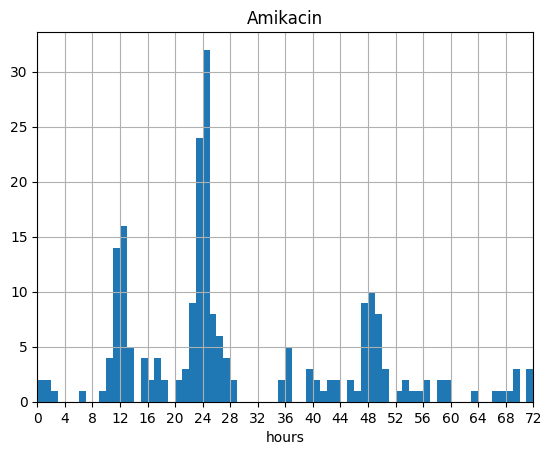

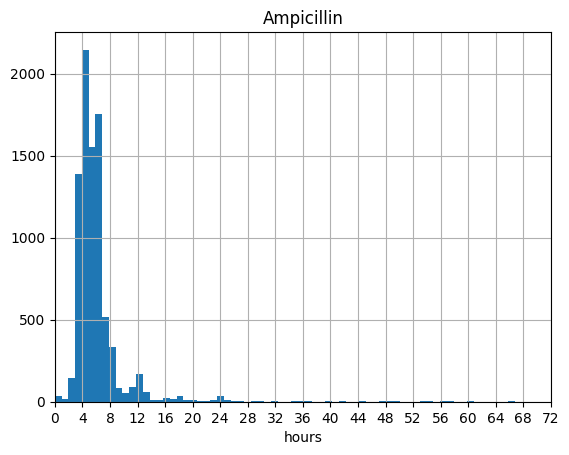

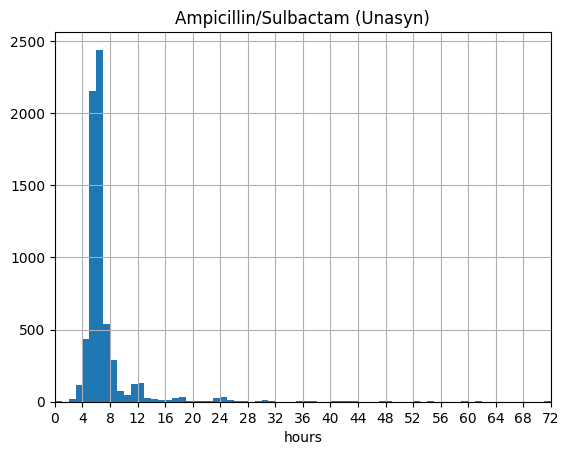

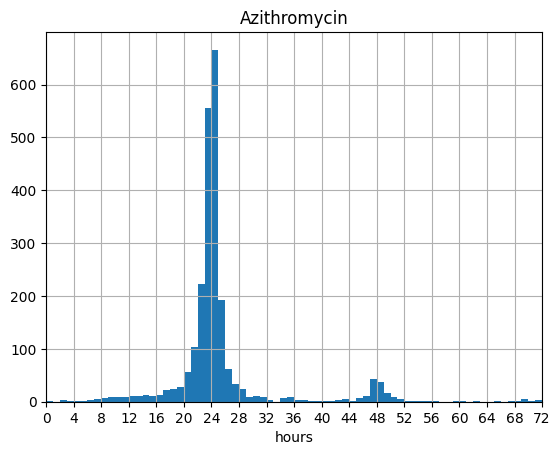

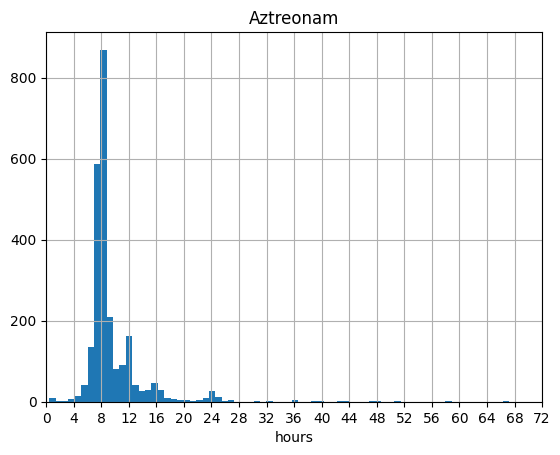

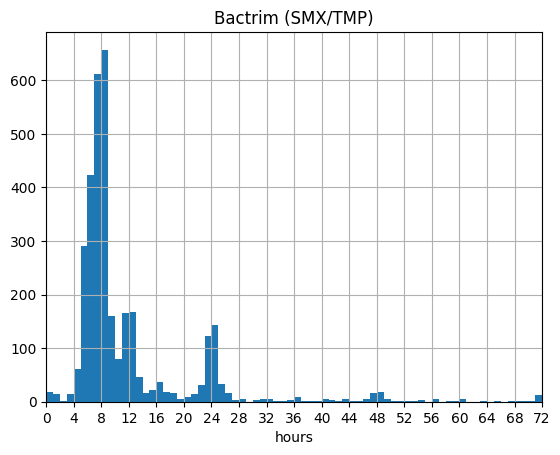

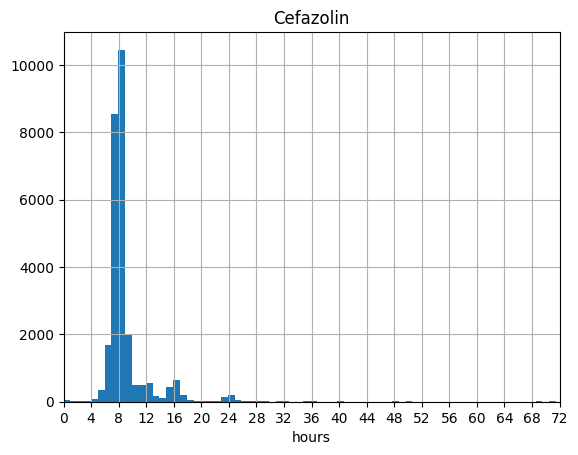

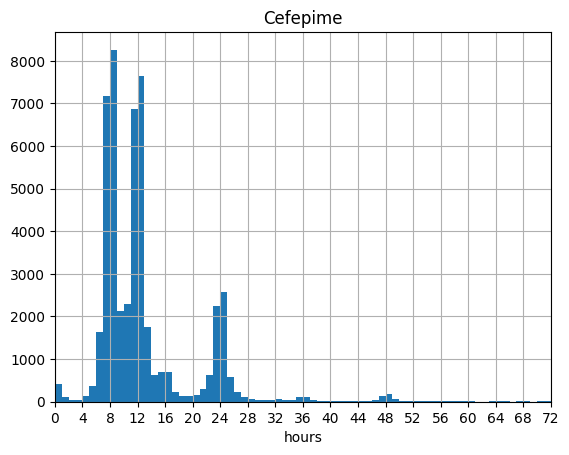

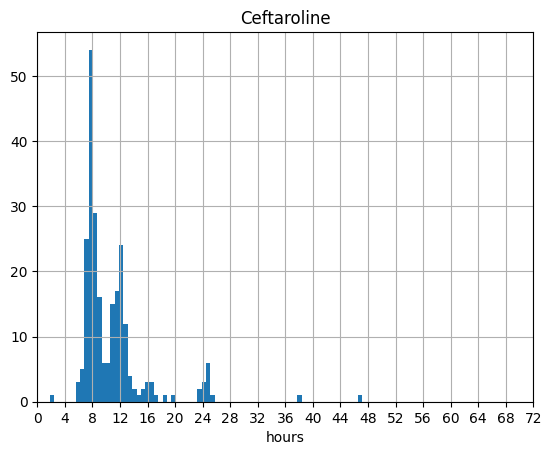

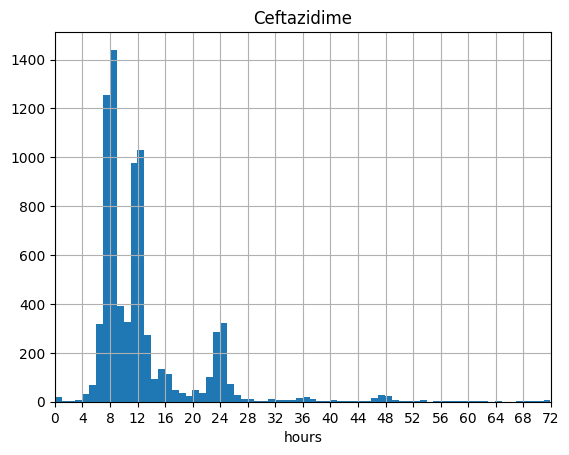

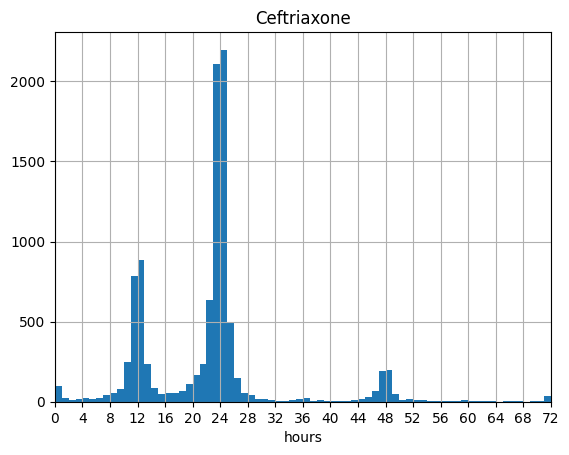

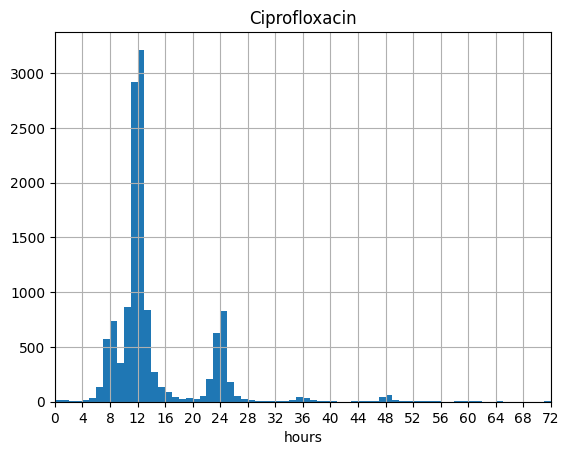

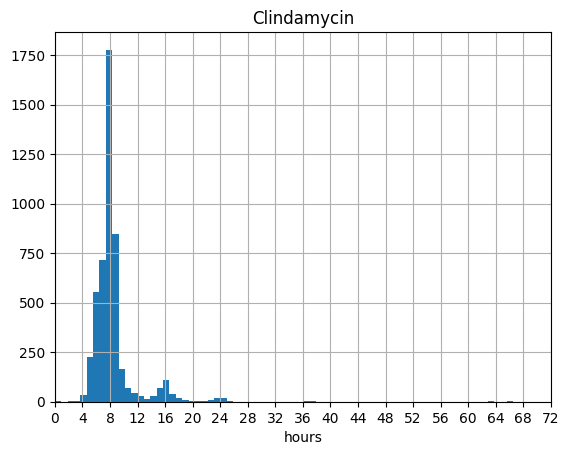

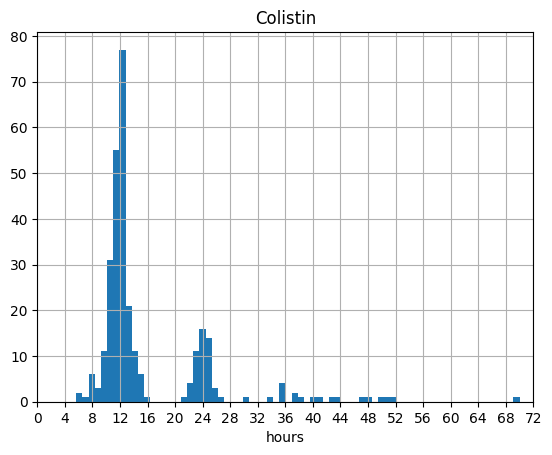

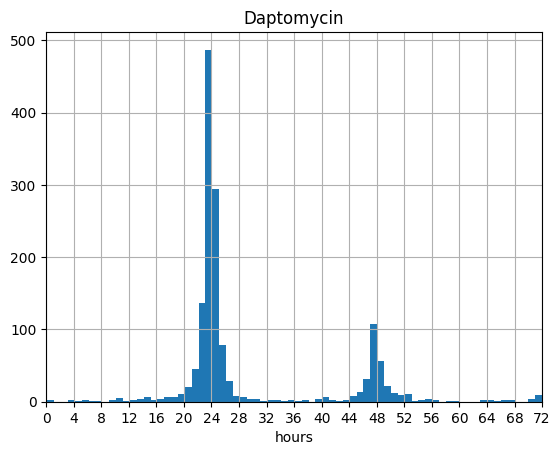

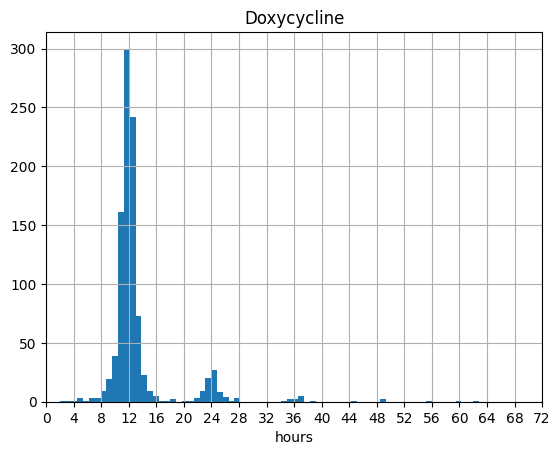

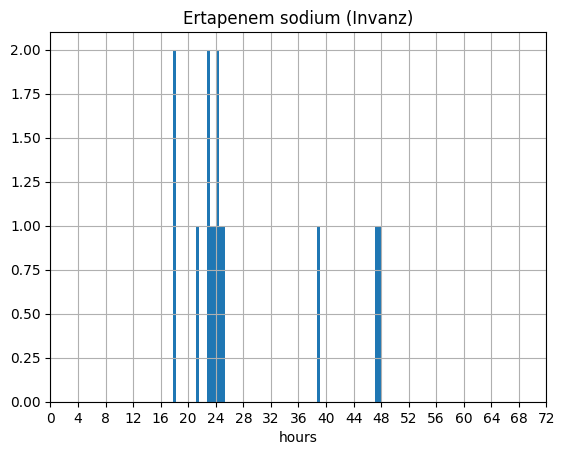

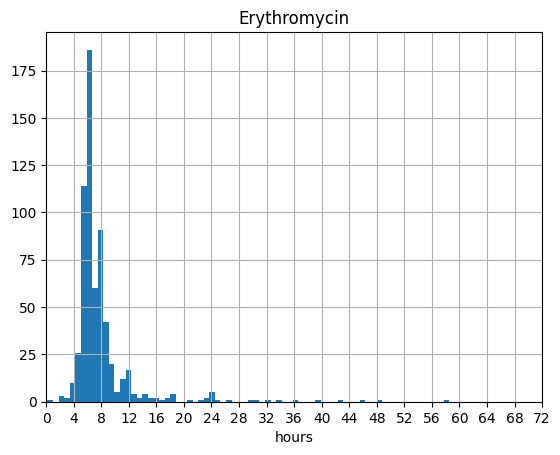

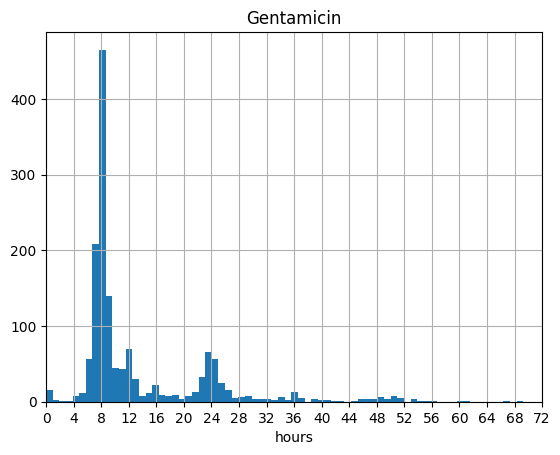

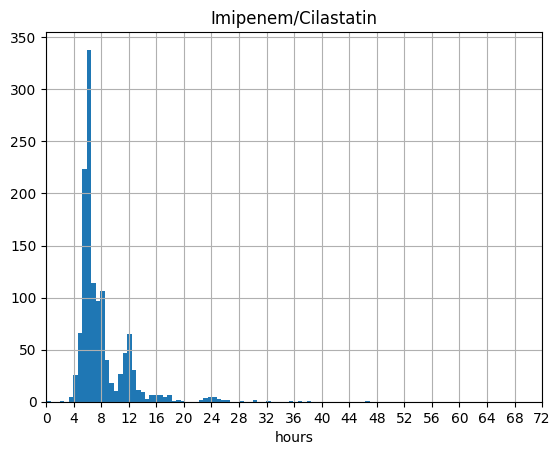

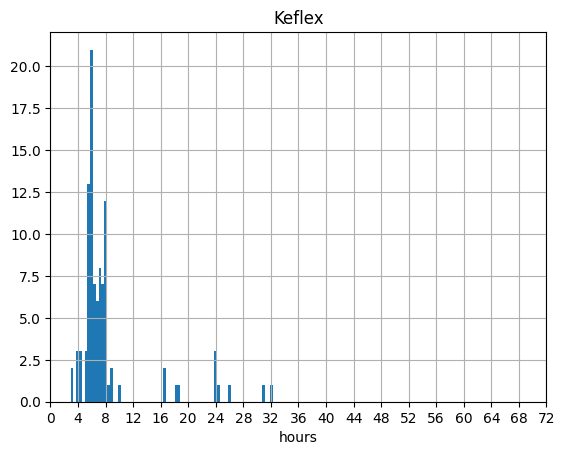

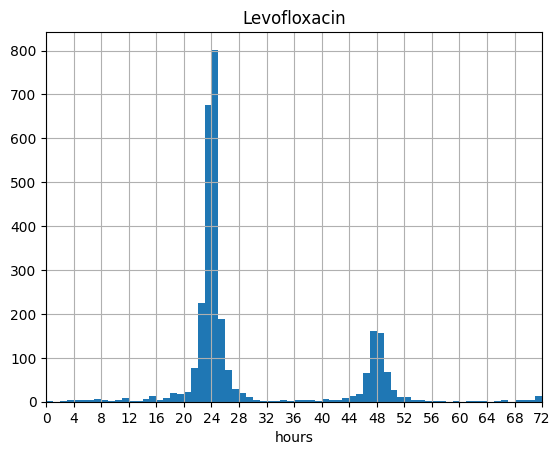

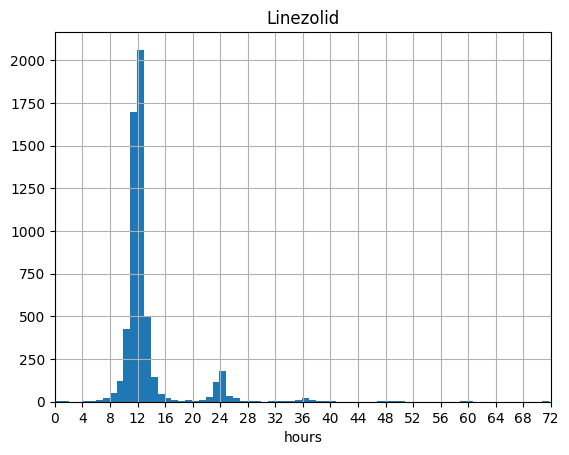

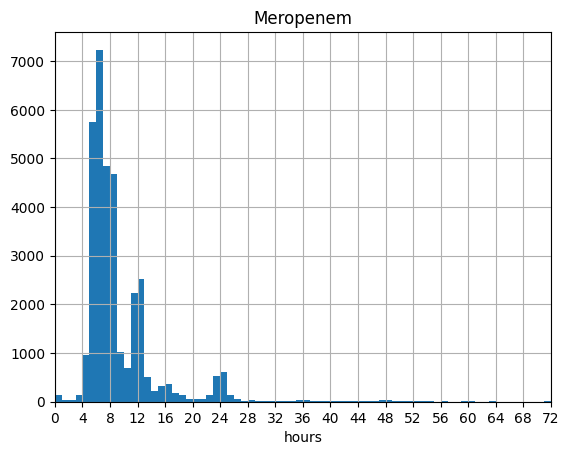

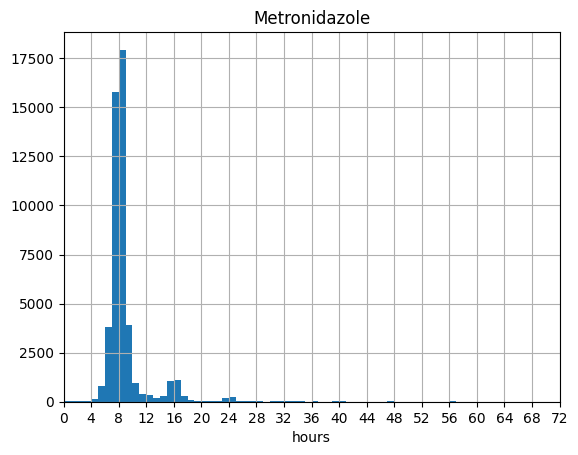

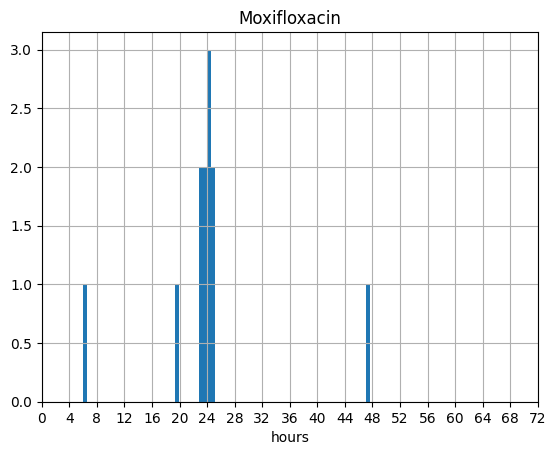

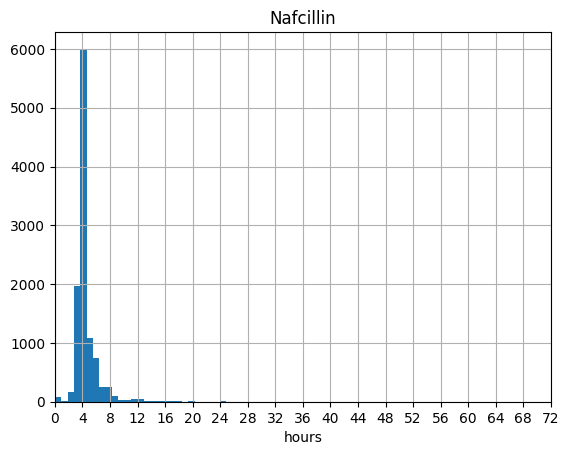

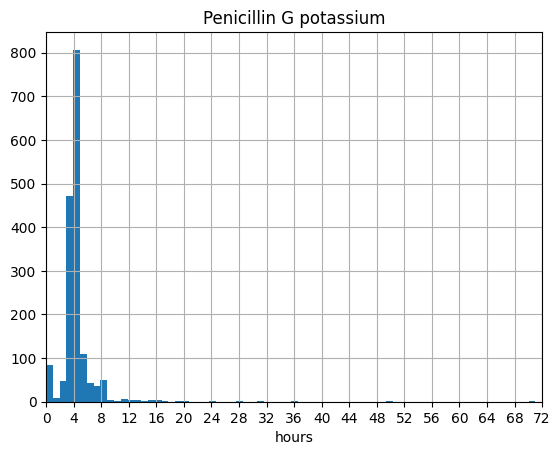

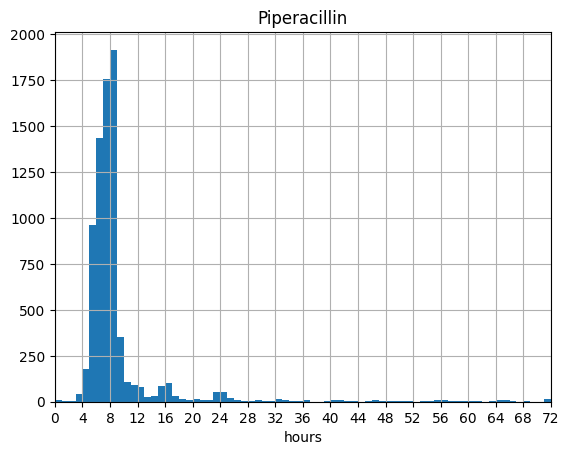

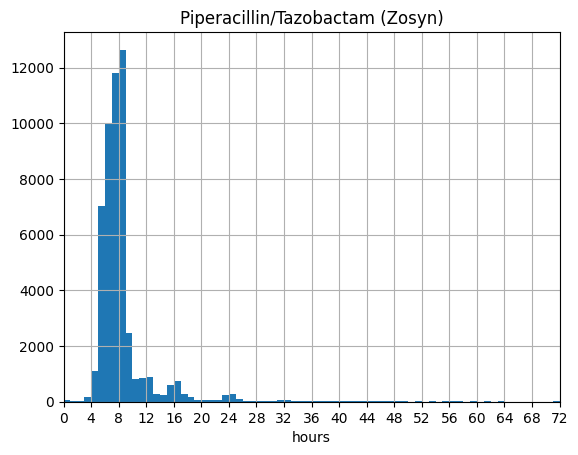

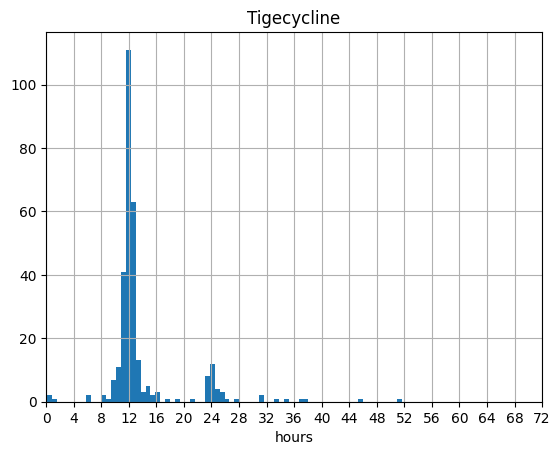

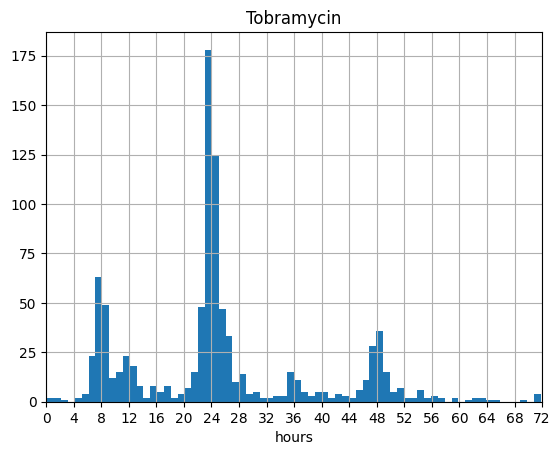

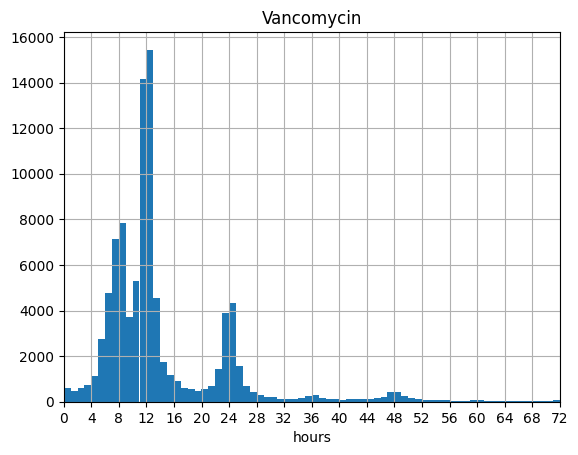

In [9]:
for i in range(len(d_antibiotics)):
    AB_label = d_antibiotics.label.unique()[i]
    AB_itemid = d_antibiotics.itemid.unique()[i]
    globals()['{}'.format(AB_label)][globals()['{}'.format(AB_label)]['timediff_days']<=3].timediff_days.hist(bins=72)
    plt.title(AB_label)
    plt.xlim(0,3)
    plt.xticks(np.arange(3*6+1)/6,np.arange(3*6+1)*4)
    plt.xlabel('hours')
    plt.show()

# Multitherapy

In [10]:
def multitherapy(inputevents_antibiotics, time):
    AB_multitherapy = pd.concat([inputevents_antibiotics,inputevents_antibiotics.shift(1)],axis=1)
    AB_multitherapy.columns = ['stay_id_x','starttime_x','itemid_x','count_x','stay_id_y','starttime_y','itemid_y','count_y']
    AB_multitherapy['timediff'] = AB_multitherapy['starttime_x'] - AB_multitherapy['starttime_y']
    AB_multitherapy['timediff'] = AB_multitherapy.timediff.dt.total_seconds()/60

    AB_multitherapy['multi'] = 0
    AB_multitherapy.loc[(AB_multitherapy['timediff']<time)&(AB_multitherapy['stay_id_x']==AB_multitherapy['stay_id_y']), 'multi'] = 1
    AB_multitherapy.loc[AB_multitherapy['multi']==1, 'starttime_x'] = np.nan

    AB_multitherapy = AB_multitherapy.ffill()
    AB_multitherapy = AB_multitherapy[['stay_id_x','starttime_x','itemid_x','count_x']]

    AB_multitherapy.drop_duplicates(inplace=True)
    AB_multitherapy_pivot = AB_multitherapy.pivot(index=['stay_id_x','starttime_x'],columns='itemid_x',values='count_x')
    AB_multitherapy_pivot.reset_index(drop=False,inplace=True)
    AB_multitherapy_pivot.fillna(0,inplace=True)
    AB_multitherapy_pivot = AB_multitherapy_pivot.rename(columns={'stay_id_x':'stay_id', 'starttime_x':'starttime'})
    AB_multitherapy_pivot.columns.name = None

    AB_multitherapy_pivot['count'] = AB_multitherapy_pivot[AB_multitherapy_pivot.columns[2:]].sum(axis=1)
    return AB_multitherapy_pivot

In [11]:
def multitherapy_diff(multi):
    multi_diff = multi[['stay_id','starttime']]
    multi_diff['starttime'] = pd.to_datetime(multi_diff['starttime'])

    multi_diff = pd.concat([multi_diff,multi_diff.shift(1)],axis=1)
    multi_diff.columns = ['stay_id_x','starttime_x','stay_id_y','starttime_y']
    multi_diff.loc[multi_diff['stay_id_x']==multi_diff['stay_id_y'],'timediff'] = multi_diff['starttime_x'] - multi_diff['starttime_y']

    multi_diff['timediff'] = multi_diff.timediff.dt.total_seconds()/(60*60)

    return multi_diff

In [12]:
def plot_multitherapy(multi, i):
    multi_1_diff = multitherapy_diff(multi)
    multi_1_diff[multi_1_diff['timediff']<=1].timediff.hist(bins=60-i)
    plt.xlim(0,1)
    plt.ylim(0,8000)
    plt.xticks(np.arange(12+1)/12,np.arange(12+1)*5)
    plt.title("%i minute"%i)

In [13]:
multi_1 = multitherapy(inputevents_antibiotics, 1)
multi_1['count'].value_counts()

count
1.0    476182
2.0     14992
3.0       480
4.0         5
Name: count, dtype: int64

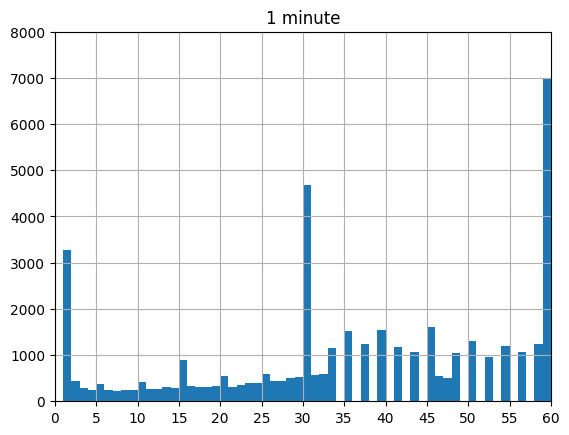

In [14]:
plot_multitherapy(multi_1, 1)

In [15]:
multi_2 = multitherapy(inputevents_antibiotics, 2)
multi_2['count'].value_counts()

count
1.0    469943
2.0     17741
3.0       693
4.0        11
Name: count, dtype: int64

In [16]:
multi_3 = multitherapy(inputevents_antibiotics, 3)
multi_3['count'].value_counts()

count
1.0    469113
2.0     18119
3.0       712
4.0        12
Name: count, dtype: int64

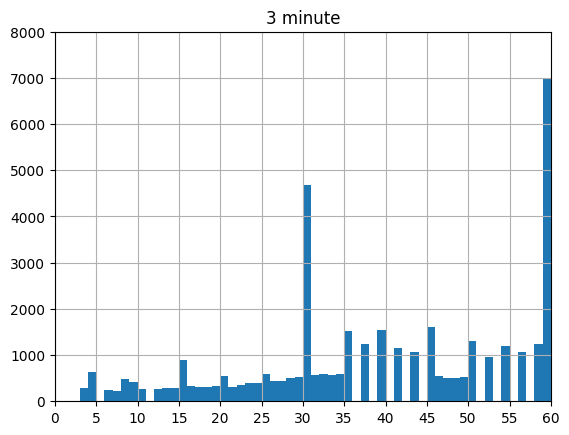

In [17]:
plot_multitherapy(multi_3, 3)

In [18]:
multi_5 = multitherapy(inputevents_antibiotics, 5)
multi_5['count'].value_counts()

count
1.0    468087
2.0     18581
3.0       735
4.0        12
Name: count, dtype: int64

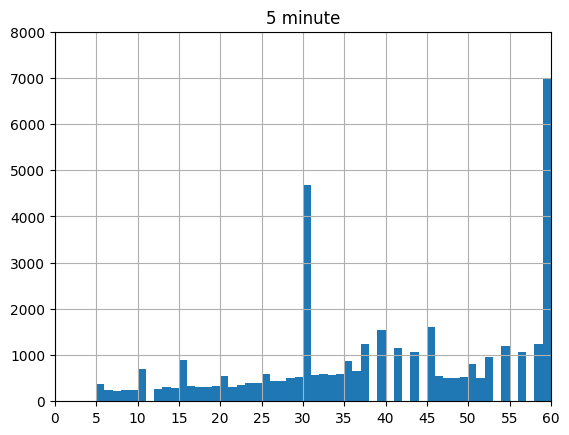

In [19]:
plot_multitherapy(multi_5, 5)

In [20]:
multi_10 = multitherapy(inputevents_antibiotics, 10)
multi_10['count'].value_counts()

count
1.0    465530
2.0     19739
3.0       790
4.0        13
Name: count, dtype: int64

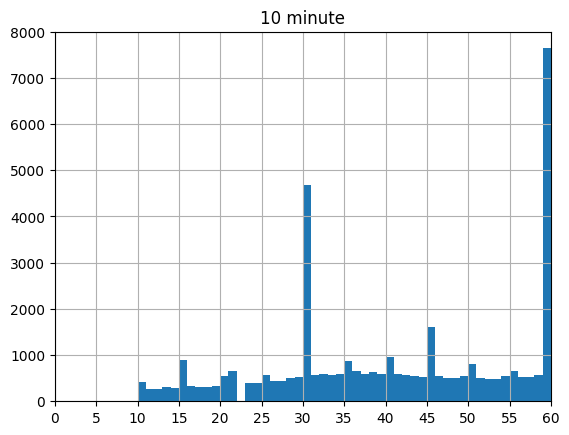

In [21]:
plot_multitherapy(multi_10, 10)

# Resample

In [22]:
def resample_multitherapy(multi,icustays_intime,icustays_outtime,resample_time):
    multi_resample = []
    for i in tqdm(multi.stay_id.unique()):
        tmp = multi[multi['stay_id']==i]
        tmp_intime = icustays_intime[icustays_intime['stay_id']==i][['stay_id','starttime']]
        tmp_outtime = icustays_outtime[icustays_outtime['stay_id']==i][['stay_id','starttime']]
        tmp = pd.concat([tmp, tmp_intime, tmp_outtime])
        tmp.fillna(0, inplace=True)
        tmp = tmp[(tmp['starttime'].values >= tmp_intime.starttime.values)&(tmp['starttime'].values <= tmp_outtime.starttime.values)]
        tmp.index = pd.DatetimeIndex(tmp['starttime'])
        tmp = tmp[tmp.columns[2:]].resample(resample_time).sum()
        tmp.reset_index(drop=False,inplace=True)
        tmp['stay_id'] = i
        multi_resample.append(tmp)
    multi_resample = pd.concat(multi_resample)
    return multi_resample

In [23]:
all = [225798,225840,225842,225843,225845,225850,225851,225853,
       225855,225859,225860,225862,225863,225865,225866,225875,
       225876,225879,225881,225883,225884,225886,225888,225890,
       225892,225893,225899,225902,227691,229061,229064,229587]

Cephalosporins = [225851,225850,225855,225853,229587,227691]
Vancomycin = [225798]
Betalactam_comb = [225893,225843]
Metronidazole = [225884]
Carbapenems = [225883,225876,229061]
Penicillins = [225888,225892,225842,225890]
Fluoroquinolones = [225859,225879,225886]
Others = [225875,225902,225840,225847,225860,225845,
          225866,225881,225863,225862,225899,225865,229064]

category = ['Cephalosporins','Vancomycin','Betalactam_comb','Metronidazole','Carbapenems','Penicillins','Fluoroquinolones','Others']

In [24]:
for i in [1,2,3,5,10]:
    globals()['multi_{}_resample'.format(i)] = resample_multitherapy(globals()['multi_{}'.format(i)],icustays_intime,icustays_outtime, 'H')
    globals()['multi_{}_resample'.format(i)]['count'] = globals()['multi_{}_resample'.format(i)][all].sum(axis=1)

    globals()['multi_{}_resample_30min'.format(i)] = resample_multitherapy(globals()['multi_{}'.format(i)],icustays_intime,icustays_outtime, '30T')
    globals()['multi_{}_resample_30min'.format(i)]['count'] = globals()['multi_{}_resample_30min'.format(i)][all].sum(axis=1)

  0%|          | 0/44426 [00:00<?, ?it/s]

  0%|          | 0/44426 [00:00<?, ?it/s]

  0%|          | 0/44426 [00:00<?, ?it/s]

  0%|          | 0/44426 [00:00<?, ?it/s]

  0%|          | 0/44426 [00:00<?, ?it/s]

  0%|          | 0/44426 [00:00<?, ?it/s]

  0%|          | 0/44426 [00:00<?, ?it/s]

  0%|          | 0/44426 [00:00<?, ?it/s]

  0%|          | 0/44426 [00:00<?, ?it/s]

  0%|          | 0/44426 [00:00<?, ?it/s]

In [25]:
Cephalosporins

[225851, 225850, 225855, 225853, 229587, 227691]

In [26]:
for i in [1,2,3,5,10]:
    for j in category:
        globals()['multi_{}_resample'.format(i)][j] = globals()['multi_{}_resample'.format(i)][globals()['{}'.format(j)]].sum(axis=1)
        globals()['multi_{}_resample_30min'.format(i)][j] = globals()['multi_{}_resample_30min'.format(i)][globals()['{}'.format(j)]].sum(axis=1)

        globals()['multi_{}_resample'.format(i)].loc[globals()['multi_{}_resample'.format(i)][j] > 0, j] = 1
        globals()['multi_{}_resample_30min'.format(i)].loc[globals()['multi_{}_resample_30min'.format(i)][j] > 0, j] = 1

        globals()['multi_{}_resample'.format(i)].reset_index(inplace=True,drop=True)
        globals()['multi_{}_resample_30min'.format(i)].reset_index(inplace=True,drop=True)

In [27]:
for i in tqdm([1,2,3,5,10]):
    globals()['multi_{}_resample'.format(i)]['count_category'] = globals()['multi_{}_resample'.format(i)][category].sum(axis=1)
    globals()['multi_{}_resample_30min'.format(i)]['count_category'] = globals()['multi_{}_resample_30min'.format(i)][category].sum(axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
for i in [1,2,3,5,10]:
    print(globals()['multi_{}_resample'.format(i)]['count_category'].value_counts())

count_category
0.0    4354448
1.0     439902
2.0      31214
3.0       1260
4.0         21
Name: count, dtype: int64
count_category
0.0    4354541
1.0     439724
2.0      31295
3.0       1264
4.0         21
Name: count, dtype: int64
count_category
0.0    4354593
1.0     439632
2.0      31331
3.0       1267
4.0         22
Name: count, dtype: int64
count_category
0.0    4354672
1.0     439484
2.0      31399
3.0       1267
4.0         23
Name: count, dtype: int64
count_category
0.0    4354894
1.0     439072
2.0      31574
3.0       1282
4.0         23
Name: count, dtype: int64


In [29]:
for i in [1,2,3,5,10]:
    globals()['stay_id_gt2dose_{}'.format(i)] = globals()['multi_{}_resample'.format(i)][globals()['multi_{}_resample'.format(i)]['count_category'] > 2].stay_id.unique()
    print(len(globals()['stay_id_gt2dose_{}'.format(i)]))

919
920
922
923
934


In [30]:
for i in [1,2,3,5,10]:
    print(globals()['multi_{}_resample_30min'.format(i)]['count_category'].value_counts())

count_category
0.0    9126377
1.0     460365
2.0      21896
3.0        842
4.0         14
Name: count, dtype: int64
count_category
0.0    9126536
1.0     460063
2.0      22028
3.0        853
4.0         14
Name: count, dtype: int64
count_category
0.0    9126606
1.0     459936
2.0      22080
3.0        857
4.0         15
Name: count, dtype: int64
count_category
0.0    9126722
1.0     459716
2.0      22183
3.0        858
4.0         15
Name: count, dtype: int64
count_category
0.0    9127081
1.0     459037
2.0      22486
3.0        875
4.0         15
Name: count, dtype: int64


In [31]:
for i in [1,2,3,5,10]:
    globals()['stay_id_gt2dose_{}_30min'.format(i)] = globals()['multi_{}_resample_30min'.format(i)][globals()['multi_{}_resample_30min'.format(i)]['count_category'] > 2].stay_id.unique()
    print(len(globals()['stay_id_gt2dose_{}_30min'.format(i)]))

652
659
661
662
675


In [32]:
for i in [1,2,3,5,10]:
    globals()['multi_{}_resample_cat'.format(i)] = globals()['multi_{}_resample'.format(i)][~globals()['multi_{}_resample'.format(i)]['stay_id'].isin(globals()['stay_id_gt2dose_{}'.format(i)])]
    globals()['multi_{}_resample_cat_30min'.format(i)] = globals()['multi_{}_resample_30min'.format(i)][~globals()['multi_{}_resample_30min'.format(i)]['stay_id'].isin(globals()['stay_id_gt2dose_{}_30min'.format(i)])]

In [33]:
def create_concat_column(row):
    return ' '.join([str(row[col]) for col in category if row[col] != 0])

In [34]:
def category_counts(multi_1_resample_cat):
    tmp = pd.DataFrame(multi_1_resample_cat[category].value_counts()).reset_index()
    for i in category:
        tmp.loc[tmp[i]>0, i] = i
    tmp['Antibiotics'] = tmp.apply(create_concat_column, axis=1)
    tmp = tmp[['Antibiotics','count']]
    return tmp

In [35]:
for i in [1,2,3,5,10]:
    for j in ['','_30min']:
        globals()['multi_{}_category_counts{}'.format(i,j)] = category_counts(globals()['multi_{}_resample_cat{}'.format(i,j)])

In [36]:
multi_5_resample_cat

,starttime,225798,225840,225842,225843,225845,225847,225850,225851,225853,...,stay_id,Cephalosporins,Vancomycin,Betalactam_comb,Metronidazole,Carbapenems,Penicillins,Fluoroquinolones,Others,count_category
0,2136-01-14 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30000484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2136-01-14 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30000484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2136-01-14 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30000484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2136-01-14 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30000484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2136-01-14 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30000484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4826840,2129-01-29 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39999562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4826841,2129-01-29 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39999562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4826842,2129-01-29 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39999562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4826843,2129-01-29 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39999562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
